In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


# Часть 1. Классификатор 128×128

In [3]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, selected_classes=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.all_class_names = [line.strip() for line in f]
        
        # Берем 4 класса
        if selected_classes is None:
            self.class_names = self.all_class_names[:4]
        else:
            self.class_names = selected_classes[:4] 
        
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        
        self.samples = []
        
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in self.class_names:
                cls_dir = os.path.join(train_dir, cls)
                if not os.path.exists(cls_dir):
                    continue
                    
                img_dir = os.path.join(cls_dir, 'images')
                if not os.path.exists(img_dir):
                    continue
                    
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))
                    
        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls and cls in self.class_to_idx:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# Трансформы для 128x128
# У меня не получалось установить albumentations, поэтому я использовала torchvision, а потом вдруг получилось, поэтому в части 2 и 3 используются другие аугментации

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # как A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5) из семинара
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Просто ресайз до 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Использованные аугментации:

- Отображение по горизонтали с вероятностью 50%
- Случайное зменение яркости и контраста

In [5]:
root = r"C:\Users\giber\Desktop\homework\магистр\3 семестр\нейронки комьютер вижен\дз2\data\tiny-imagenet-200 1\tiny-imagenet-200"

selected = [
    'n02279972', #butterfly
    'n01774384', #black widow
    'n01945685', #slug
    'n02190166', #fly
]

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform, selected_classes=selected)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform, selected_classes=selected)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Classes: {train_dataset.class_names}")

batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Train size: 1800
Val size: 200
Classes: ['n02279972', 'n01774384', 'n01945685', 'n02190166']


In [6]:
# Модель

class Сlassificator(nn.Module):
    def __init__(self, num_classes=4):
        super(Сlassificator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)  # 64
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2)  # 32
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        
        # gap
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x
    
# Проверка
model = Сlassificator(num_classes=4).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Параметров: {total_params:,}")
print(f"Модель:\n{model}")

Параметров: 1,572,612
Модель:
Сlassificator(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05,

In [7]:
# Функции для обучения

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total


In [9]:
model = Сlassificator(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 10
best_val_acc = 0

for epoch in range(num_epochs):
    
    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Валидация
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Сохраняем лучшую модель
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_128class.pth')

    print(f"{epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    scheduler.step()

1 | Train Loss: 1.3650 | Train Acc: 35.33% | Val Loss: 1.4319 | Val Acc: 40.50%
2 | Train Loss: 1.3054 | Train Acc: 40.56% | Val Loss: 1.8888 | Val Acc: 39.50%
3 | Train Loss: 1.2729 | Train Acc: 41.61% | Val Loss: 1.9186 | Val Acc: 49.50%
4 | Train Loss: 1.2077 | Train Acc: 46.33% | Val Loss: 1.5884 | Val Acc: 47.00%
5 | Train Loss: 1.1859 | Train Acc: 47.78% | Val Loss: 1.4899 | Val Acc: 52.50%
6 | Train Loss: 1.1416 | Train Acc: 51.78% | Val Loss: 1.4689 | Val Acc: 57.50%
7 | Train Loss: 1.1349 | Train Acc: 51.22% | Val Loss: 1.6343 | Val Acc: 51.50%
8 | Train Loss: 1.0952 | Train Acc: 53.17% | Val Loss: 1.3592 | Val Acc: 50.00%
9 | Train Loss: 1.0479 | Train Acc: 55.22% | Val Loss: 1.2545 | Val Acc: 59.50%
10 | Train Loss: 1.0461 | Train Acc: 55.17% | Val Loss: 1.3969 | Val Acc: 59.00%


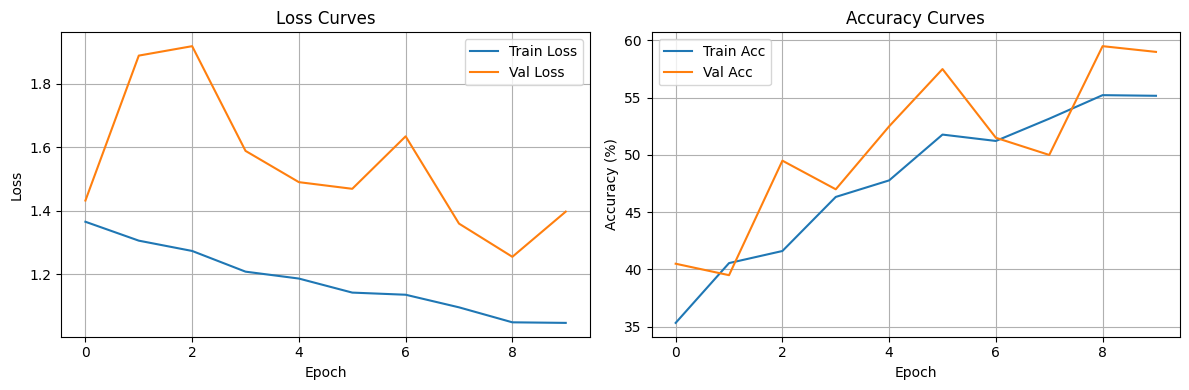

Лучшая val accuracy: 59.50%
Финальный val loss: 1.2545
Финальная val accuracy: 59.50%


In [10]:
# Графики

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

model.load_state_dict(torch.load('best_model_128class.pth'))
val_loss, val_acc = validate(model, val_loader, criterion, device)

print(f"Лучшая val accuracy: {best_val_acc:.2f}%")
print(f"Финальный val loss: {val_loss:.4f}")
print(f"Финальная val accuracy: {val_acc:.2f}%")

In [ ]:
# Сохранение чекпоинта

torch.save({
    'model_state_dict': model.state_dict(),
    'val_acc': val_acc,
    'val_loss': val_loss,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
}, 'final_checkpoint_128class.pth')

# Часть 2. Базовая U-Net на "Луне"

Требования к архитектуре U-Net (зафиксируйте и опишите в отчёте):

Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).

Базовые каналы на первом уровне: 32 или 64 (по желанию можно выбрать свое количество каналов, но надо будет объяснить).

Даунсемплинг: stride 2 или MaxPool.

Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).

Ограничение на количество параметров: до ~2.5M (рекомендуется укладываться, но допускается ±10%).

Вход: 128×128×3.

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# Датасет как в семинаре
class MoonSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        # Для масок убираем префикс "render" если он есть
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)
        
        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

In [5]:
def get_preprocessing():
    return A.Compose([ToTensorV2()])

# Аугментации для обучения
train_aug = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomRotate90(p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

val_aug = A.Compose([
    A.Resize(128, 128),
])

preprocessing = get_preprocessing()

C:\Users\giber\AppData\Local\Temp\ipykernel_17988\3986685654.py:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


In [ ]:
# U-Net

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):
        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        return output
    
model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

# Проверка
test_input = torch.randn(1, 3, 128, 128)
output = model(test_input)
print(f"вход: {test_input.shape}")
print(f"выход: {output.shape}")

Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
вход: torch.Size([1, 3, 128, 128])
выход: torch.Size([1, 1, 128, 128])


Сделала меньше каналов, чтобы уменьшить количество параметров и увеличить скорость работы на маленьких мощностях

In [ ]:
root = "./MOON_SEGMENTATION_BINARY"

full_dataset = MoonSegmentationDataset(
    root_dir=root,
    augmentation=None,
    preprocessing=None
)

image_ids = full_dataset.image_ids
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)}")
print(f"Val: {len(val_ids)}")

train_dataset = MoonSegmentationDataset(
    root_dir=root,
    image_ids=train_ids,
    augmentation=train_aug,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=root,
    image_ids=val_ids,
    augmentation=val_aug,
    preprocessing=preprocessing
)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Train: 800
Val: 200


In [ ]:
# Метрики

class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()


def calculate_metrics(predictions, targets, threshold=0.5):
    iou = iou_score(predictions, targets, threshold)
    dice = dice_coefficient(predictions, targets, threshold)
    acc = pixel_accuracy(predictions, targets, threshold)
    
    return iou, dice, acc

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, masks in loader:
        images = images.float().to(device)
        masks = masks.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    total_acc = 0
    
    with torch.no_grad():
        for images, masks in loader:
            # Конвертируем в float32
            images = images.float().to(device)
            masks = masks.float().unsqueeze(1).to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            iou, dice, acc = calculate_metrics(outputs, masks)
            total_iou += iou
            total_dice += dice
            total_acc += acc
    
    n = len(loader)
    return total_loss/n, total_iou/n, total_dice/n, total_acc/n

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = UNet(features=[16, 32, 64, 128]).to(device)

# Используем комбинированный лосс
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение
num_epochs = 20
train_losses = []
val_losses = []
val_ious = []
val_dices = []
val_accs = []
best_iou = 0

for epoch in range(num_epochs):
    # Обучение
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Валидация
    val_loss, val_iou, val_dice, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    val_accs.append(val_acc) 
    
    # Сохраняем лучшую модель
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_unet_moon.pth')
    
    # Print all metrics including Pixel Accuracy
    print(f"{epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f} | Pixel Acc: {val_acc:.4f}")

Device: cpu
Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
  1 | Train Loss: 0.6611 | Val Loss: 0.5842 | IoU: 0.3127 | Dice: 0.4722 | Pixel Acc: 0.8721
  2 | Train Loss: 0.5494 | Val Loss: 0.6062 | IoU: 0.2471 | Dice: 0.3924 | Pixel Acc: 0.7774
  3 | Train Loss: 0.4935 | Val Loss: 0.4480 | IoU: 0.3095 | Dice: 0.4703 | Pixel Acc: 0.9147
  4 | Train Loss: 0.4562 | Val Loss: 0.4291 | IoU: 0.3329 | Dice: 0.4959 | Pixel Acc: 0.9096
  5 | Train Loss: 0.4532 | Val Loss: 0.4053 | IoU: 0.3513 | Dice: 0.5171 | Pixel Acc: 0.9146
  6 | Train Loss: 0.4351 | Val Loss: 0.4099 | IoU: 0.3524 | Dice: 0.5179 | Pixel Acc: 0.8914
  7 | Train Loss: 0.4279 | Val Loss: 0.3675 | IoU: 0.3950 | Dice: 0.5624 | Pixel Acc: 0.9159
  8 | Train Loss: 0.4240 | Val Loss: 0.3791 | IoU: 0.3750 | Dice: 0.5408 | Pixel Acc: 0.9099
  9 | Train Loss: 0.4230 | Val Loss: 0.3742 | IoU: 0.3934 | Dice: 0.5611 | Pixel Acc: 0.9147
 10 | Train Loss: 0.4215 | Val Loss: 0.3671 | IoU: 0.3844 | Dice: 0.55

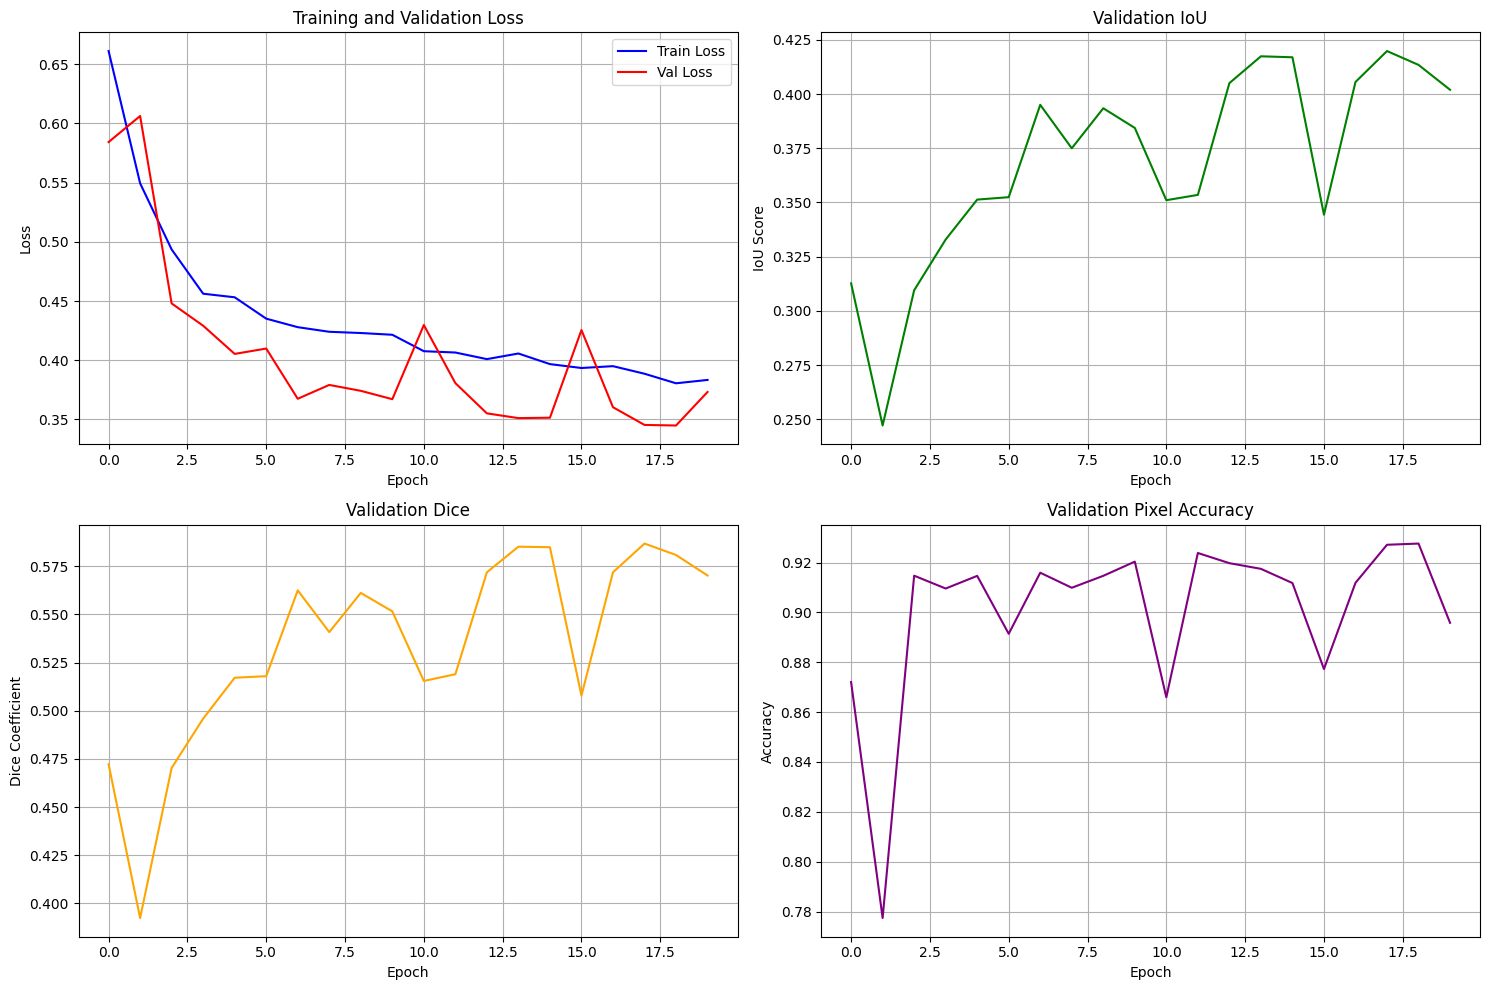

In [ ]:
# Графики

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(val_ious, label='IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.title('Validation IoU')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(val_dices, label='Dice', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(val_accs, label='Pixel Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Pixel Accuracy')
plt.grid()

plt.tight_layout()
plt.savefig('unet_training_curves.png')
plt.show()

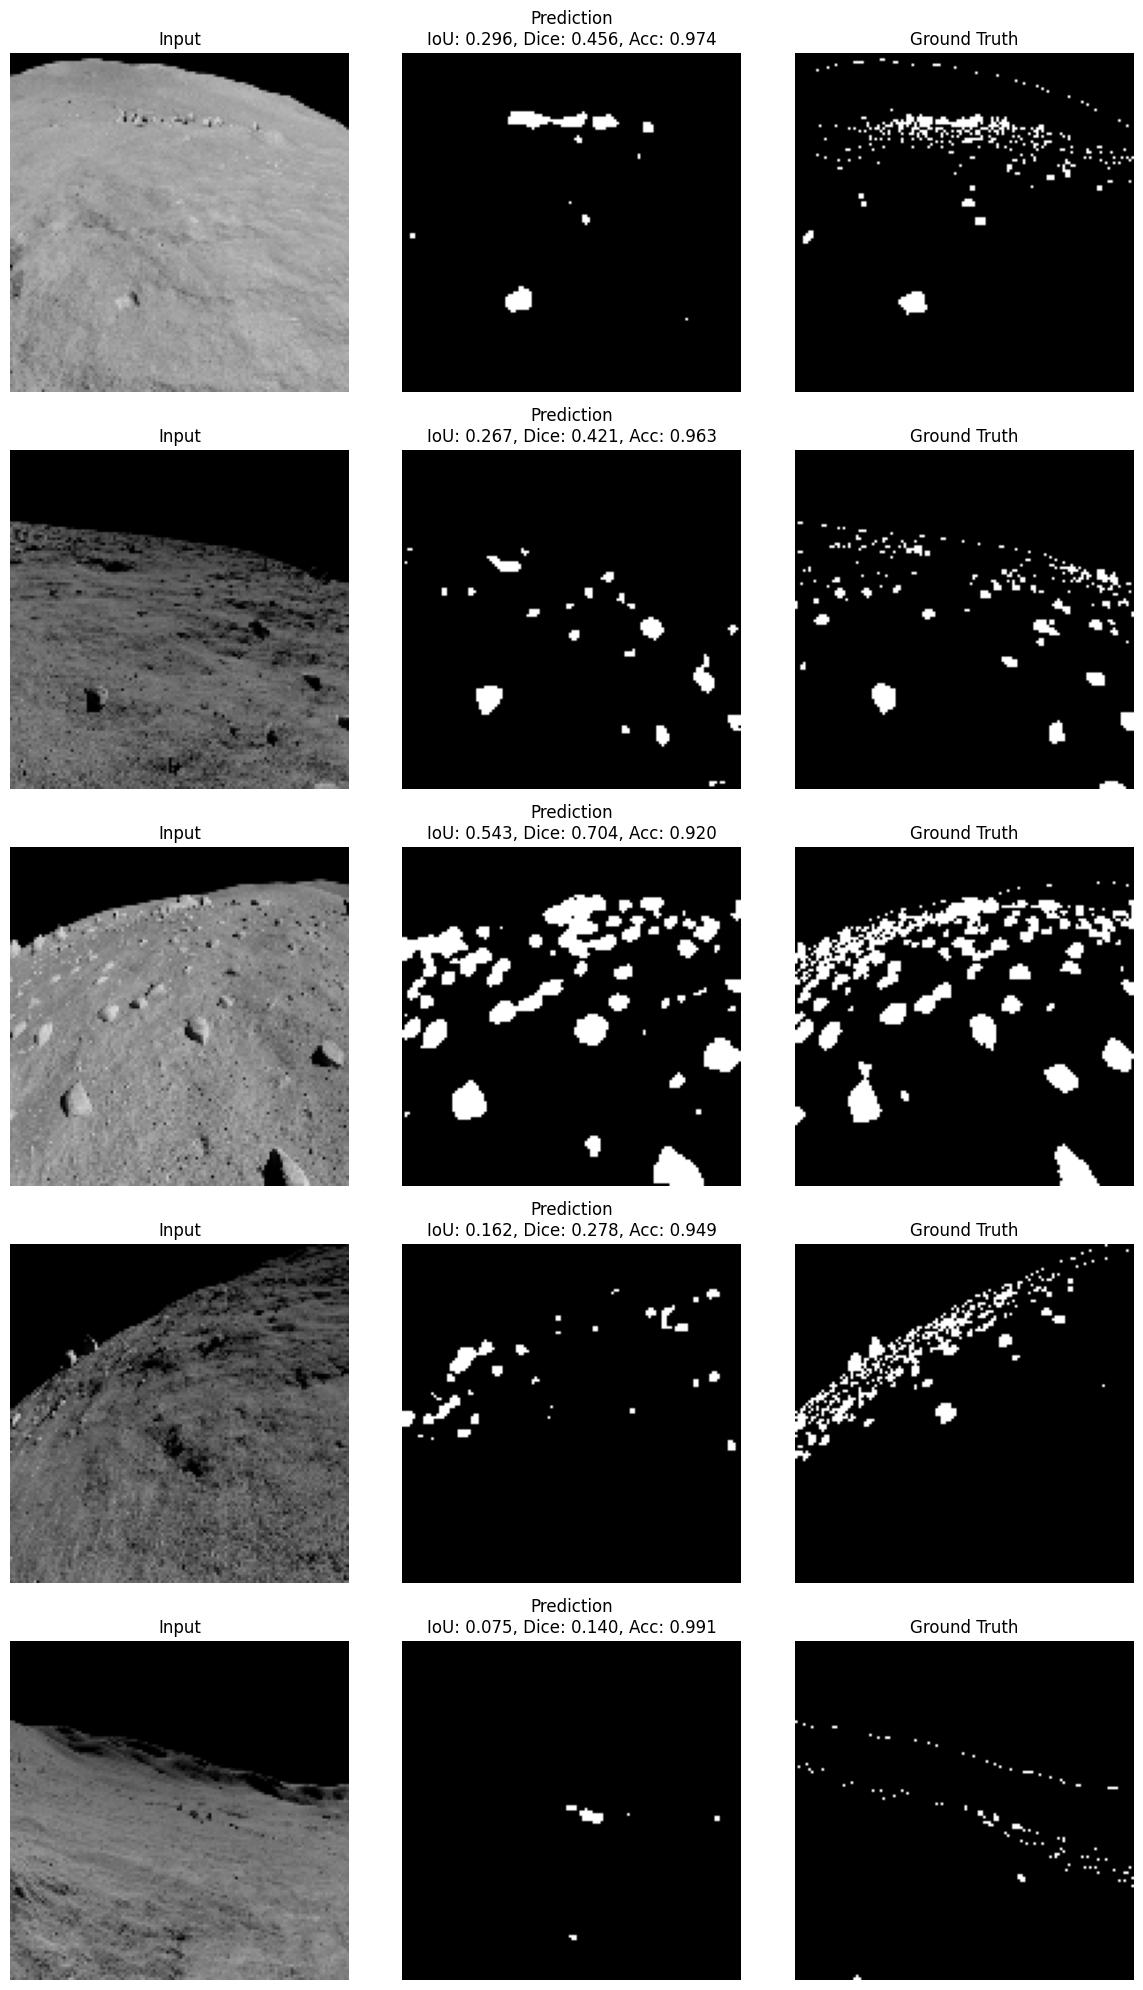

In [ ]:
# Визуализация

model.load_state_dict(torch.load('best_unet_moon.pth'))
model.eval()

fig, axes = plt.subplots(5, 3, figsize=(12, 20))

with torch.no_grad():
    for i in range(5):
        idx = np.random.randint(len(val_dataset))
        image, mask = val_dataset[idx]
        
        image_tensor = image.float().unsqueeze(0).to(device)
        mask_tensor = mask.float().unsqueeze(0).unsqueeze(0).to(device)
        
        pred = model(image_tensor)
        pred_mask = (torch.sigmoid(pred) > 0.5).float()
        
        iou, dice, acc = calculate_metrics(pred, mask_tensor)
        
        img_disp = image.permute(1, 2, 0).cpu().numpy()
        gt_disp = mask.cpu().numpy()
        pred_disp = pred_mask[0, 0].cpu().numpy()
        
        axes[i, 0].imshow(img_disp)
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pred_disp, cmap='gray')
        axes[i, 1].set_title(f'Prediction\nIoU: {iou:.3f}, Dice: {dice:.3f}, Acc: {acc:.3f}')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(gt_disp, cmap='gray')
        axes[i, 2].set_title('Ground Truth')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Часть 3. U-Net с бэкбоном из классификатора

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Датасет (тот же)
class MoonSegmentationDataset:
    def __init__(self, root_dir, image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', 'render')
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', 'render', f"{image_id}.png")
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', 'ground', f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = (mask > 0).astype(np.float32)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
    
    # Загрузка данных
root = "./MOON_SEGMENTATION_BINARY"

full_dataset = MoonSegmentationDataset(root_dir=root)
image_ids = full_dataset.image_ids
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}")

train_dataset = MoonSegmentationDataset(
    root_dir=root,
    image_ids=train_ids,
    augmentation=train_aug,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=root,
    image_ids=val_ids,
    augmentation=val_aug,
    preprocessing=preprocessing
)

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



Train: 800, Val: 200


In [7]:
# Метрики (как в части 2)

class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()


def calculate_metrics(predictions, targets, threshold=0.5):
    iou = iou_score(predictions, targets, threshold)
    dice = dice_coefficient(predictions, targets, threshold)
    acc = pixel_accuracy(predictions, targets, threshold)
    
    return iou, dice, acc

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [9]:
# U-Net с backbone из классификатора

# Загружаем модель классификатора
classifier_checkpoint = torch.load('best_model_128class.pth', map_location='cpu')

# Архитектуру классификатора (та же что в части 1)
class Classifier(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)  
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2)  
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Создаем и загружаем веса классификатора
classifier_model = Classifier(num_classes=4)
classifier_model.load_state_dict(classifier_checkpoint)
print("Классификатор загружен")

# U-Net с бэкбоном из классификатора
class ClassifierUNet(nn.Module):
    def __init__(self, classifier_model):
        super().__init__()
        
        # Берем слои из классификатора
        self.enc1_conv = classifier_model.conv1
        self.enc1_bn = classifier_model.bn1
        
        self.enc2_conv = classifier_model.conv2
        self.enc2_bn = classifier_model.bn2
        self.pool1 = classifier_model.pool1
        
        self.enc3_conv = classifier_model.conv3
        self.enc3_bn = classifier_model.bn3
        
        self.enc4_conv = classifier_model.conv4
        self.enc4_bn = classifier_model.bn4
        self.pool2 = classifier_model.pool2
        
        self.enc5_conv = classifier_model.conv5
        self.enc5_bn = classifier_model.bn5
        
        # Замораживаем все
        for param in self.enc1_conv.parameters():
            param.requires_grad = False
        for param in self.enc2_conv.parameters():
            param.requires_grad = False
        for param in self.enc3_conv.parameters():
            param.requires_grad = False
        for param in self.enc4_conv.parameters():
            param.requires_grad = False
        for param in self.enc5_conv.parameters():
            param.requires_grad = False
        
        # Декодер
        self.upconv1 = nn.ConvTranspose2d(512, 128, 2, 2)  # 128
        self.dec1_conv1 = nn.Conv2d(384, 128, 3, padding=1) 
        self.dec1_bn1 = nn.BatchNorm2d(128)
        self.dec1_conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.dec1_bn2 = nn.BatchNorm2d(128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, 2)  # 64
        self.dec2_conv1 = nn.Conv2d(192, 64, 3, padding=1)  # 128+64=192
        self.dec2_bn1 = nn.BatchNorm2d(64)
        self.dec2_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec2_bn2 = nn.BatchNorm2d(64)
        
        self.adapt_enc2 = nn.Conv2d(64, 32, 1)  # 32
        self.adapt_enc1 = nn.Conv2d(32, 32, 1)  # 32
        self.adapt_dec2 = nn.Conv2d(64, 64, 1)  # 64

        self.dec3_conv1 = nn.Conv2d(128, 32, 3, padding=1)  # 64+32+32=128
        self.dec3_bn1 = nn.BatchNorm2d(32)
        self.dec3_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.dec3_bn2 = nn.BatchNorm2d(32)
        
        self.final = nn.Conv2d(32, 1, 1)
    
    def forward(self, x):
        
        # Энкодер
        enc1 = F.relu(self.enc1_bn(self.enc1_conv(x)))  # 32
        
        enc2 = F.relu(self.enc2_bn(self.enc2_conv(enc1)))  # 64
        enc2_pool = self.pool1(enc2)  # 64
        
        enc3 = F.relu(self.enc3_bn(self.enc3_conv(enc2_pool)))  # 128
        
        enc4 = F.relu(self.enc4_bn(self.enc4_conv(enc3)))  # 256
        enc4_pool = self.pool2(enc4)  # 256
        
        enc5 = F.relu(self.enc5_bn(self.enc5_conv(enc4_pool)))  # 512
        
        # Декодер
        dec1 = self.upconv1(enc5)  # 128
        dec1 = torch.cat([enc4, dec1], dim=1)  # 256+128=384
        dec1 = F.relu(self.dec1_bn1(self.dec1_conv1(dec1)))
        dec1 = F.relu(self.dec1_bn2(self.dec1_conv2(dec1)))  # 128
        
        dec2 = self.upconv2(dec1)  # 64
        enc3_up = F.interpolate(enc3, size=(128, 128), mode='bilinear', align_corners=True)
        dec2 = torch.cat([enc3_up, dec2], dim=1)  # 128+64=192
        dec2 = F.relu(self.dec2_bn1(self.dec2_conv1(dec2)))
        dec2 = F.relu(self.dec2_bn2(self.dec2_conv2(dec2)))  # 64
        
        enc2_up = F.interpolate(enc2_pool, size=(128, 128), mode='bilinear', align_corners=True)
        enc2_adapted = self.adapt_enc2(enc2_up)  # 32
        
        enc1_adapted = self.adapt_enc1(enc1)  # 32
        
        dec2_adapted = self.adapt_dec2(dec2)  # 64
        
        dec3 = torch.cat([dec2_adapted, enc2_adapted, enc1_adapted], dim=1)  # 128
        dec3 = F.relu(self.dec3_bn1(self.dec3_conv1(dec3)))
        dec3 = F.relu(self.dec3_bn2(self.dec3_conv2(dec3)))  # 32
        
        out = self.final(dec3) 
        
        return out
    
# Проверка
model = ClassifierUNet(classifier_model)

frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Заморожено: {frozen:,}")
print(f"Обучаемо: {trainable:,}")
print(f"Всего: {frozen + trainable:,}")

# Тест
test_input = torch.randn(1, 3, 128, 128)
output = model(test_input)
print(f"\nвход: {test_input.shape}")
print(f"выход: {output.shape}")

Классификатор загружен
Заморожено: 1,568,576
Обучаемо: 1,089,121
Всего: 2,657,697

вход: torch.Size([1, 3, 128, 128])
выход: torch.Size([1, 1, 128, 128])


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = model.to(device)

criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

encoder_params = []
decoder_params = []

for name, param in model.named_parameters():
    if 'enc' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 1e-5}, 
    {'params': decoder_params, 'lr': 1e-3}])


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
)

NUM_EPOCHS = 10
SAVE_PATH = 'best_classifier_unet.pth'

print(f"Эпох: {NUM_EPOCHS}")
print(f"Encoder LR: 1e-5")
print(f"Decoder LR: 1e-3")
print(f"Сохраняем в: {SAVE_PATH}")

Device: cpu
Эпох: 10
Encoder LR: 1e-5
Decoder LR: 1e-3
Сохраняем в: best_classifier_unet.pth


In [35]:
# Функции для обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, save_path):
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    val_accs = []
    best_iou = 0
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images = images.float().to(device)
            masks = masks.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Val
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_acc = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.float().to(device)
                masks = masks.float().unsqueeze(1).to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                iou, dice, acc = calculate_metrics(outputs, masks)
                val_iou += iou
                val_dice += dice
                val_acc += acc
        
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_dice /= len(val_loader)
        val_acc /= len(val_loader)
        
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_dices.append(val_dice)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        
        # Сохранить best
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'val_iou': val_iou,
                'val_dice': val_dice,
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, save_path)
        
        print(f"{epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f} | Acc: {val_acc:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_ious': val_ious,
        'val_dices': val_dices,
        'val_accs': val_accs,
    }

In [36]:
# Обучение
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path=SAVE_PATH)

1 | Train Loss: 0.5483 | Val Loss: 0.5248 | IoU: 0.2550 | Dice: 0.3917 | Acc: 0.8189
2 | Train Loss: 0.5165 | Val Loss: 0.4645 | IoU: 0.2524 | Dice: 0.3920 | Acc: 0.9094
3 | Train Loss: 0.5125 | Val Loss: 0.4697 | IoU: 0.2636 | Dice: 0.4076 | Acc: 0.8974
4 | Train Loss: 0.5015 | Val Loss: 0.4486 | IoU: 0.2669 | Dice: 0.4103 | Acc: 0.9165
5 | Train Loss: 0.4913 | Val Loss: 0.4751 | IoU: 0.2229 | Dice: 0.3560 | Acc: 0.9130
6 | Train Loss: 0.4922 | Val Loss: 0.4515 | IoU: 0.3043 | Dice: 0.4527 | Acc: 0.9031
7 | Train Loss: 0.4841 | Val Loss: 0.4583 | IoU: 0.2547 | Dice: 0.3958 | Acc: 0.9093
8 | Train Loss: 0.4858 | Val Loss: 0.4406 | IoU: 0.2778 | Dice: 0.4240 | Acc: 0.9115
9 | Train Loss: 0.4813 | Val Loss: 0.4335 | IoU: 0.3241 | Dice: 0.4736 | Acc: 0.9070
10 | Train Loss: 0.4836 | Val Loss: 0.4305 | IoU: 0.3114 | Dice: 0.4622 | Acc: 0.9163


Best epoch: 9
Best IoU: 0.3241
Best Dice: 0.4736
Best Pixel Acc: 0.9070


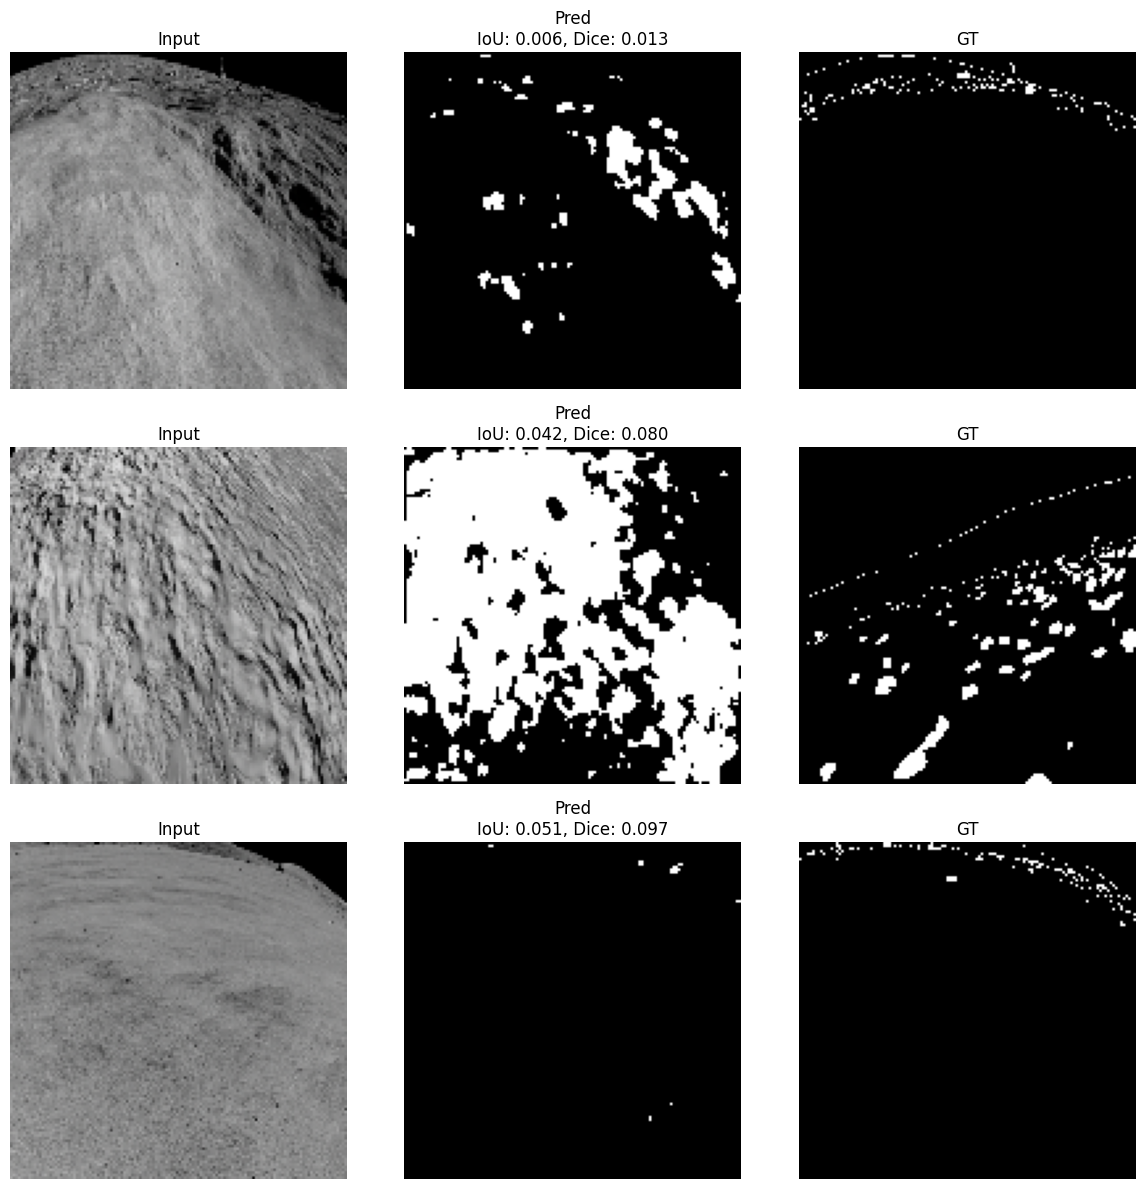

In [ ]:
# Загрузка лучшей модели
best_model = ClassifierUNet(classifier_model)
checkpoint = torch.load(SAVE_PATH, map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

print(f"Best epoch: {checkpoint['epoch']}")
print(f"Best IoU: {checkpoint['val_iou']:.4f}")
print(f"Best Dice: {checkpoint['val_dice']:.4f}")
print(f"Best Pixel Acc: {checkpoint['val_acc']:.4f}")

# Визуализация предсказаний
best_model.eval()

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

with torch.no_grad():
    for i in range(3):
        idx = np.random.randint(len(val_dataset))
        image, mask = val_dataset[idx]
        
        image_tensor = image.float().unsqueeze(0).to(device)
        mask_tensor = mask.float().unsqueeze(0).unsqueeze(0).to(device)
        
        pred = best_model(image_tensor)
        pred_mask = (torch.sigmoid(pred) > 0.5).float()
        iou, dice, acc = calculate_metrics(pred, mask_tensor)
        
        img_disp = image.permute(1, 2, 0).cpu().numpy()
        gt_disp = mask.cpu().numpy()
        pred_disp = pred_mask[0, 0].cpu().numpy()
        
        axes[i, 0].imshow(img_disp)
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pred_disp, cmap='gray')
        axes[i, 1].set_title(f'Pred\nIoU: {iou:.3f}, Dice: {dice:.3f}')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(gt_disp, cmap='gray')
        axes[i, 2].set_title('GT')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

| Модель | Показатель | На 10-й эпохе | Лучший результат (эпоха) |
|---|---|---|---|
| **U-Net (Базовая)** | **Параметры** | **1,944,049** | — |
| | Train Loss | 0.4215 | 0.3805 (19) |
| | Val Loss | 0.3671 | 0.3449 (19) |
| | IoU | 0.3844 | 0.4198 (18) |
| | Dice | 0.5516 | 0.5867 (18) |
| | Pixel Acc | 0.9204 | **0.9276** (19) |
| **U-Net с бэкбоном** | **Параметры** | **2,657,697** | — |
| | Train Loss | 0.4836 | 0.4813 (9) |
| | Val Loss | 0.4305 | 0.4305 (10) |
| | IoU | 0.3114 | 0.3241 (9) |
| | Dice | 0.4622 | 0.4736 (9) |
| | Pixel Acc | 0.9163 | 0.9165 (4) |

Модель с бэкбоном демонстрирует менее стабильное обучение с колебаниями метрик. 